In [1]:
import os
import math
import gzip
import pickle
from random import gauss
from itertools import product
from time import sleep
from datetime import datetime, timedelta, date
from urllib import request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm

%matplotlib inline

In [52]:
def plot_cv(df, train_idx, test_idx, i, n=5, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(n, 1, i)
    plt.axis([
        df.index.min(),
        df.index.max(),
        df.cl.min() * 0.99,
        df.cl.max() * 1.01
    ])
    plt.plot(df.iloc[train_idx].cl,
             ls='',
             marker='o',
             markersize=1,
             label='train')
    plt.plot(df.iloc[test_idx].cl,
             ls='',
             marker='o',
             markersize=1,
             label='test')
    plt.tight_layout()
    plt.legend()

# データ準備

In [3]:
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    df = pickle.load(f)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


In [4]:
#タイムバーの作成
FREQ = "15min"
time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = df["price"].resample(FREQ).ohlc()
volume = df["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


# 特徴量エンジニアリング

In [5]:
import talib

In [6]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df


In [17]:
calc_features(time_bar)
display(time_bar)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-03 18:00:00,42402.0,42518.5,42350.0,42496.0,10047829,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-03-03 18:15:00,42495.5,42510.0,42388.0,42400.0,7628490,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-03-03 18:30:00,42399.5,42400.0,42263.0,42269.0,12928393,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2022-03-03 18:45:00,42268.5,42428.0,42200.0,42247.0,36213372,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-03-03 19:00:00,42247.5,42421.5,42237.0,42400.0,13625602,218.011462,33.15,-151.711462,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,92.430731,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 22:15:00,45728.0,45791.5,45655.0,45783.5,7237028,134.964356,55.55,-23.864356,-140.540527,243.43104,...,0.966581,1,-0.558816,0.894727,-9.528571,82.168374,-104.042857,7.270330,39.707178,0.0
2022-03-31 22:30:00,45783.0,45787.5,45690.0,45690.0,5050202,87.056679,9.95,-67.156679,-165.817309,210.08065,...,0.853805,0,2.061099,0.859399,92.142857,84.447029,-41.571429,10.285714,38.553340,1.0
2022-03-31 22:45:00,45690.5,45800.0,45690.0,45786.0,7734788,73.42218,1.5,-70.42218,-168.148479,193.325447,...,0.633786,0,0.383537,0.815266,8.0,84.732303,-133.0,10.846154,35.961090,0.0


## ラベリング

**opとclを比べて値段が上がったかどうかでラベリングする方法**

In [43]:
# 目的変数の作成
y = time_bar.cl / time_bar.op
y = y.apply(lambda x: 1 if x > 1 else 0)
y = y.shift(-1)
time_bar["target"] = y
time_bar.dropna(inplace=True)

time_bar.to_pickle('df_features.pkl')

**固定時間ホライズン法によってラベリングする方法**

In [50]:
# h = 16  #固定時間ホライズンの設定(16/4=4時間)　15分足だから４で割ることで何時間分先の価格の予測かを求めれる。
# returns = (time_bar["cl"].diff(h).shift(-h)[:-h] /
#            time_bar["cl"][:-h]).rename('r')


# thre_r = 0.003
# labels_static = returns.apply(lambda x: x / abs(x) if abs(x) > thre_r else 0)
# #ラベルが分散するように手動で調整したが、のちに調整も自動化したい！
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(2,3,1)
# bins = np.linspace(-1, 1, 10)
# ax.hist(labels_static, bins, label=f'labels_static')
# ax.legend(loc='upper left')

# time_bar["target"] = labels_static
# time_bar.dropna(inplace=True)

# time_bar.to_pickle('df_features.pkl')



**richmanのリターンによるラベリングする方法**

毎時刻、この執行方法でトレードした場合の累積リターン


C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\cosmo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

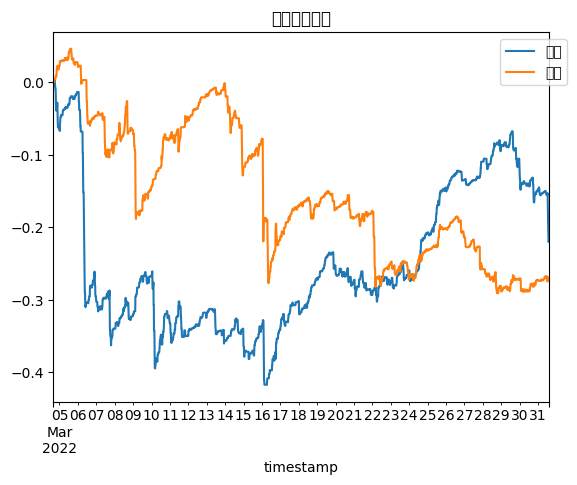

In [58]:
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
# fee = df['fee'] # maker手数料　一旦０で計算するが、richmanはdfにtimpstampに応じて変わるようにfeeを組み込んでいる。
fee = 0

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips) > (df['lo'].shift(-1) / pips)).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips) < (df['hi'].shift(-1) / pips)).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)


print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-31 13:45:00,47050.0,47094.0,46912.5,46912.5,31150944,467.782668,146.35,-175.082668,176.336237,172.971568,...,46837.5,1,46447.5,3,1.0,0.0,-0.008327,0,-0.001599,0
2022-03-31 14:00:00,46912.5,46913.0,46150.0,46485.0,225461075,973.929094,439.1,-95.729094,561.556375,600.126628,...,46388.0,1,46447.5,2,1.0,0.0,0.001283,0,-0.002087,0
2022-03-31 14:15:00,46484.5,46581.5,46267.0,46346.5,43198169,1002.494768,365.85,-270.794768,573.256074,656.723297,...,NaN,NaN,46447.5,1,0.0,1.0,0,NaN,0,-0.002179
2022-03-31 14:30:00,46346.0,46462.0,46264.0,46462.0,24148116,842.153283,288.2,-265.753283,562.599905,678.039536,...,NaN,NaN,46563.0,1,0.0,1.0,0,NaN,0,-0.002174
2022-03-31 14:45:00,46461.5,46711.0,46456.5,46688.0,33512305,394.734175,-4.95,-404.634175,305.213602,434.512792,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0


### 特徴量について調べる。

In [8]:
import seaborn as sns
time_bar.head()
# sns.heatmap(time_bar, square=True)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 22:00:00,43868.0,43868.0,43774.0,43840.0,4127124,222.605745,70.3,-82.005745,72.536391,-9.417522,...,-0.362494,0,0.522806,0.862698,83.157143,82.122515,-10.8,7.227473,76.152873,1.0
2022-03-01 22:15:00,43840.0,43960.0,43840.0,43945.5,6538919,142.120738,-9.3,-160.720738,4.971313,-79.777682,...,-0.557421,0,0.809185,0.866785,-13.185714,82.101170,-106.885714,7.207692,75.710369,1.0
2022-03-01 22:30:00,43945.5,44169.5,43939.5,44150.0,17811845,115.528242,-135.0,-385.528242,-113.817049,-213.001702,...,-0.689043,0,0.327546,0.890181,-173.871429,83.782552,-293.2,9.179121,125.264121,1.0
2022-03-01 22:45:00,44150.0,44231.0,44058.5,44158.0,9410449,120.633162,-152.55,-425.733162,-170.944514,-282.832238,...,-0.758299,0,0.417686,0.901287,-114.042857,86.710757,-340.242857,17.400000,136.591581,0.0
2022-03-01 23:00:00,44158.0,44262.5,44078.0,44125.5,7828911,129.975116,-126.45,-382.875116,-170.749582,-291.326932,...,-0.749985,0,0.352744,0.917209,-42.685714,87.190608,-307.6,20.378022,128.212558,1.0


In [9]:
#以下のコードでは学習に使う特徴量カラムを指定する。
features =sorted([
    
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


モデルの生成・学習

In [44]:
df = pd.read_pickle('df_features.pkl')
df = df.dropna()

df.head()

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-04 16:00:00,40686.0,40786.0,40367.0,40559.5,52885836,317.39656,129.9,-57.59656,397.8198,661.881325,...,-0.155889,1,0.820724,0.913303,45.728571,-89.259670,1051.771429,-77.387912,93.748280,1.0
2022-03-04 16:15:00,40560.0,40694.0,40537.0,40670.5,14638979,255.591749,73.8,-107.991749,304.944728,586.24382,...,-0.153197,1,0.920202,0.916224,-118.157143,-89.247370,871.442857,-76.123077,90.895874,1.0
2022-03-04 16:30:00,40670.5,40791.0,40529.0,40767.0,17587942,146.643668,13.8,-119.043668,224.306627,513.695832,...,-0.040042,1,0.332065,0.922667,-239.928571,-89.218762,713.428571,-73.335165,66.421834,0.0
2022-03-04 16:45:00,40767.0,40816.0,40717.0,40765.0,8956162,75.362142,-76.9,-229.162142,85.44308,380.828359,...,0.127766,0,-0.089731,0.922134,-223.214286,-89.084713,590.5,-62.593407,76.131071,1.0
2022-03-04 17:00:00,40765.5,40896.0,40680.0,40888.5,15839289,161.784683,-57.9,-277.584683,50.680316,342.629755,...,0.191299,0,-0.567176,0.922864,-289.342857,-88.794035,328.2,-47.503297,109.842342,0.0


In [45]:
#データを訓練用と検証用に分ける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[features],df["target"])

In [46]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=0)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [47]:
score = model.score(X_test, y_test)

In [48]:
score

0.5285935085007728